# Librerie

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, LSTM, GRU
import holidays
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.stattools import acf
import warnings

# Importazione dataset e preprocessing

In [2]:
df = pd.read_csv('data2022_train.csv').rename(columns={'Unnamed: 0': 'time', 'y': 'power'})
df['time'] = pd.to_datetime(df['time'])
df

,time,power
0,2017-01-01 00:00:00,34055.69620
1,2017-01-01 00:10:00,29814.68354
2,2017-01-01 00:20:00,29128.10127
3,2017-01-01 00:30:00,28228.86076
4,2017-01-01 00:40:00,27335.69620
...,...,...
48091,2017-11-30 23:10:00,31347.69231
48092,2017-11-30 23:20:00,30603.07692
48093,2017-11-30 23:30:00,29889.23077
48094,2017-11-30 23:40:00,29249.23077


# Plot serie temporale

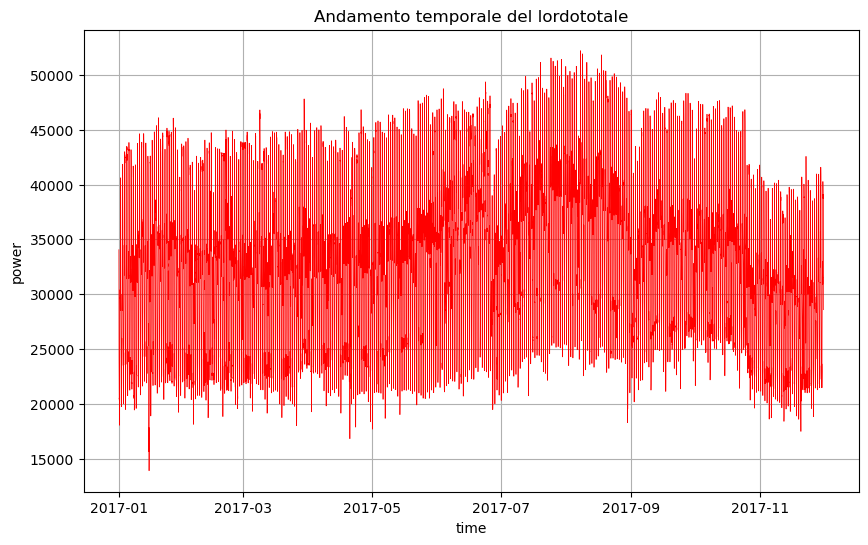

In [3]:
plt.figure(figsize=(10, 6))
plt.plot(df['time'],df['power'],
         color='red', linewidth=0.5)
plt.title('Andamento temporale del lordototale')
plt.xlabel('time')
plt.ylabel('power')
plt.grid(True)
# Salva il grafico ad alta qualità
#plt.savefig('Rist1_nocov.png', dpi=300, bbox_inches='tight')
plt.show()

# Divisione training e test

In [4]:
# Preparazione dei dati
data = df['power'].values
data = data.reshape(-1, 1) 

# Divisione tra dati di addestramento e test
train_size = len(data)-4320
train_data = data[:train_size]
test_data = data[train_size:]

# Normalizzazione dei dati
scaler = StandardScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Creazione delle finestre di dati
def create_sequences(data, window_size):
    sequences = []
    for i in range(len(data) - window_size):
        seq = data[i:i + window_size]
        label = data[i + window_size]
        sequences.append((seq, label))
    return sequences

window_size = 10
train_sequences = create_sequences(train_data, window_size)
test_sequences = create_sequences(test_data, window_size)

X_train = np.array([seq for seq, label in train_sequences])
y_train = np.array([label for seq, label in train_sequences])
X_test = np.array([seq for seq, label in test_sequences])
y_test = np.array([label for seq, label in test_sequences])

# Definizione, addestramento RNN

In [5]:
# Creazione del modello RNN
model_RNN = Sequential([
    SimpleRNN(32, activation='relu', input_shape=(window_size, 1)),
    Dense(1)
])

# Compilazione del modello con MSE
model_RNN.compile(optimizer='adam', loss='mean_squared_error')

# Definizione dell'early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Addestramento del modello con early stopping
history_RNN = model_RNN.fit(X_train, y_train, epochs=100, batch_size=16,
                        validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/100
2736/2736 [==============================] - 4s 1ms/step - loss: 0.0139 - val_loss: 0.0034
Epoch 2/100
2736/2736 [==============================] - 3s 1ms/step - loss: 0.0039 - val_loss: 0.0031
Epoch 3/100
2736/2736 [==============================] - 3s 1ms/step - loss: 0.0037 - val_loss: 0.0032
Epoch 4/100
2736/2736 [==============================] - 3s 1ms/step - loss: 0.0036 - val_loss: 0.0029
Epoch 5/100
2736/2736 [==============================] - 3s 1ms/step - loss: 0.0035 - val_loss: 0.0032
Epoch 6/100
2736/2736 [==============================] - 3s 1ms/step - loss: 0.0035 - val_loss: 0.0032
Epoch 7/100
2736/2736 [==============================] - 3s 1ms/step - loss: 0.0034 - val_loss: 0.0031
Epoch 8/100
2736/2736 [==============================] - 3s 1ms/step - loss: 0.0034 - val_loss: 0.0029
Epoch 9/100
2736/2736 [==============================] - 3s 1ms/step - loss: 0.0034 - val_loss: 0.0029
Epoch 10/100
2736/2736 [==============================] - 3s 1ms/step - l

# Grafico MSE

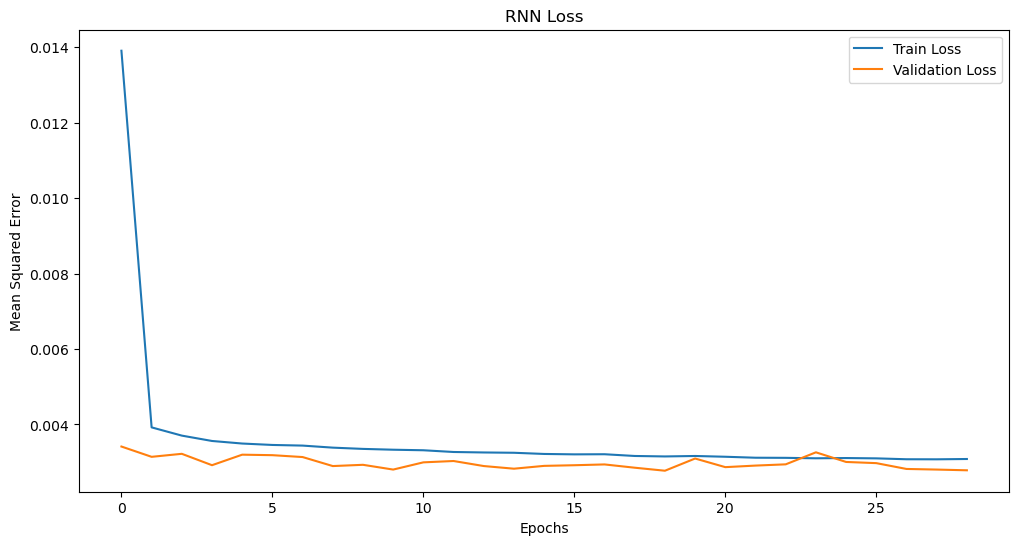

In [6]:
# Plot della curva di perdita (MSE)
plt.figure(figsize=(12, 6))
plt.plot(history_RNN.history['loss'], label='Train Loss')
plt.plot(history_RNN.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('RNN Loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
# Salva il grafico ad alta qualità
#plt.savefig('loss.png', dpi=300, bbox_inches='tight')
plt.show()

# Calcolo metriche

In [7]:
# Ignora tutti i messaggi di avviso (warning)
warnings.filterwarnings("ignore")

predictions_RNN = model_RNN.predict(X_test)
predictions_RNN_denorm = scaler.inverse_transform(predictions_RNN)
y_test_RNN_denorm = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calcola l'errore assoluto percentuale medio (MAPE)
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calcola l'errore assoluto medio (MAE)
mae = mean_absolute_error(y_test_RNN_denorm, predictions_RNN_denorm)

# Calcola l'errore quadratico medio (RMSE)
rmse = np.sqrt(mean_squared_error(y_test_RNN_denorm, predictions_RNN_denorm))

# Calcola l'errore percentuale assoluto medio (MAPE)
mape = calculate_mape(y_test_RNN_denorm, predictions_RNN_denorm)

# Creazione di un DataFrame per mostrare tutte le metriche in maniera ordinata
metrics_df = pd.DataFrame({
    'RMSE': [rmse],
    'MAE': [mae],
    'MAPE': [mape]
})

print(metrics_df)

135/135 [==============================] - 0s 625us/step
         RMSE         MAE      MAPE
0  376.373541  251.134164  0.886695


# Plot previsioni

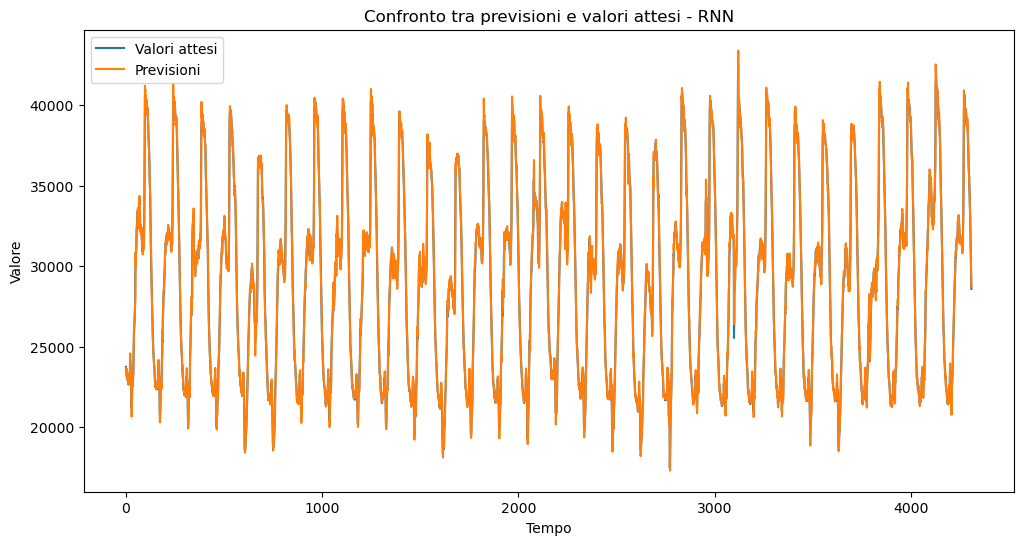

In [10]:
# Plot previsioni contro valori attesi
plt.figure(figsize=(12, 6))
plt.plot(y_test_RNN_denorm, label='Valori attesi')
plt.plot(predictions_RNN_denorm, label='Previsioni')
plt.xlabel('Tempo')
plt.ylabel('Valore')
plt.title('Confronto tra previsioni e valori attesi - RNN')
plt.legend()
# Salva il grafico ad alta qualità
#plt.savefig('RNN_previsioni.png', dpi=300, bbox_inches='tight')
plt.show()

# Definizione, addestramento LSTM

In [11]:
# Creazione del modello LSTM
model_LSTM = Sequential([
    LSTM(32, activation='relu', input_shape=(window_size, 1)),
    Dense(1)
])

# Compilazione del modello con MSE
model_LSTM.compile(optimizer='adam', loss='mean_squared_error')

# Definizione dell'early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Addestramento del modello con early stopping
history_LSTM = model_LSTM.fit(X_train, y_train, epochs=100, batch_size=16,
                         validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/100
2736/2736 [==============================] - 5s 2ms/step - loss: 0.0176 - val_loss: 0.0038
Epoch 2/100
2736/2736 [==============================] - 5s 2ms/step - loss: 0.0046 - val_loss: 0.0041
Epoch 3/100
2736/2736 [==============================] - 5s 2ms/step - loss: 0.0044 - val_loss: 0.0032
Epoch 4/100
2736/2736 [==============================] - 5s 2ms/step - loss: 0.0040 - val_loss: 0.0034
Epoch 5/100
2736/2736 [==============================] - 5s 2ms/step - loss: 0.0039 - val_loss: 0.0031
Epoch 6/100
2736/2736 [==============================] - 5s 2ms/step - loss: 0.0037 - val_loss: 0.0039
Epoch 7/100
2736/2736 [==============================] - 5s 2ms/step - loss: 0.0036 - val_loss: 0.0037
Epoch 8/100
2736/2736 [==============================] - 5s 2ms/step - loss: 0.0036 - val_loss: 0.0030
Epoch 9/100
2736/2736 [==============================] - 5s 2ms/step - loss: 0.0035 - val_loss: 0.0031
Epoch 10/100
2736/2736 [==============================] - 5s 2ms/step - l

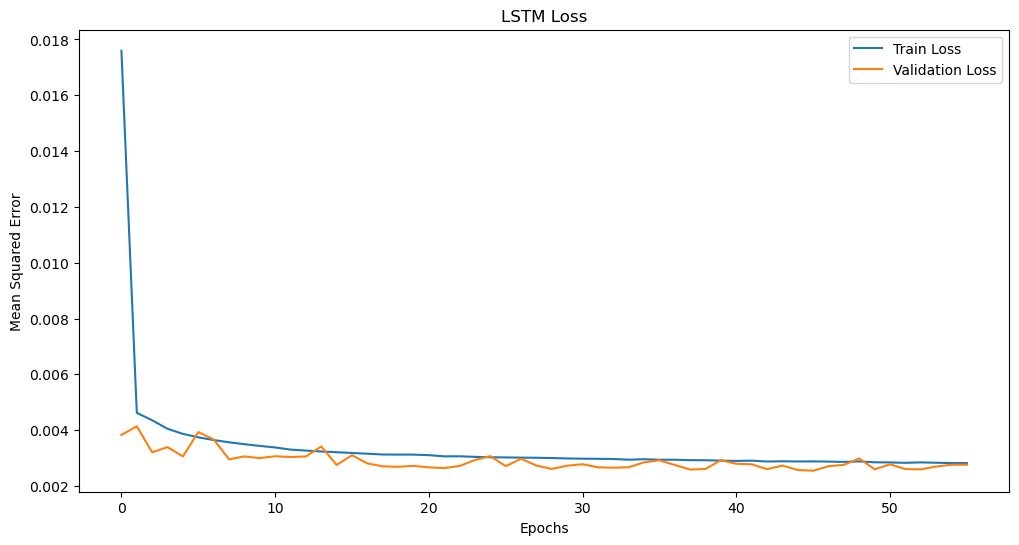

In [12]:
# Plot della curva di perdita (MSE)
plt.figure(figsize=(12, 6))
plt.plot(history_LSTM.history['loss'], label='Train Loss')
plt.plot(history_LSTM.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('LSTM Loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
# Salva il grafico ad alta qualità
#plt.savefig('loss.png', dpi=300, bbox_inches='tight')
plt.show()

In [13]:
# Ignora tutti i messaggi di avviso (warning)
warnings.filterwarnings("ignore")

predictions_LSTM = model_LSTM.predict(X_test)
predictions_LSTM_denorm = scaler.inverse_transform(predictions_LSTM)
y_test_LSTM_denorm = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calcola l'errore assoluto percentuale medio (MAPE)
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calcola l'errore assoluto medio (MAE)
mae = mean_absolute_error(y_test_LSTM_denorm, predictions_LSTM_denorm)

# Calcola l'errore quadratico medio (RMSE)
rmse = np.sqrt(mean_squared_error(y_test_LSTM_denorm, predictions_LSTM_denorm))

# Calcola l'errore percentuale assoluto medio (MAPE)
mape = calculate_mape(y_test_LSTM_denorm, predictions_LSTM_denorm)

# Creazione di un DataFrame per mostrare tutte le metriche in maniera ordinata
metrics_df = pd.DataFrame({
    'RMSE': [rmse],
    'MAE': [mae],
    'MAPE': [mape]
})

print(metrics_df)

135/135 [==============================] - 0s 878us/step
         RMSE         MAE     MAPE
0  360.539201  243.001899  0.85558


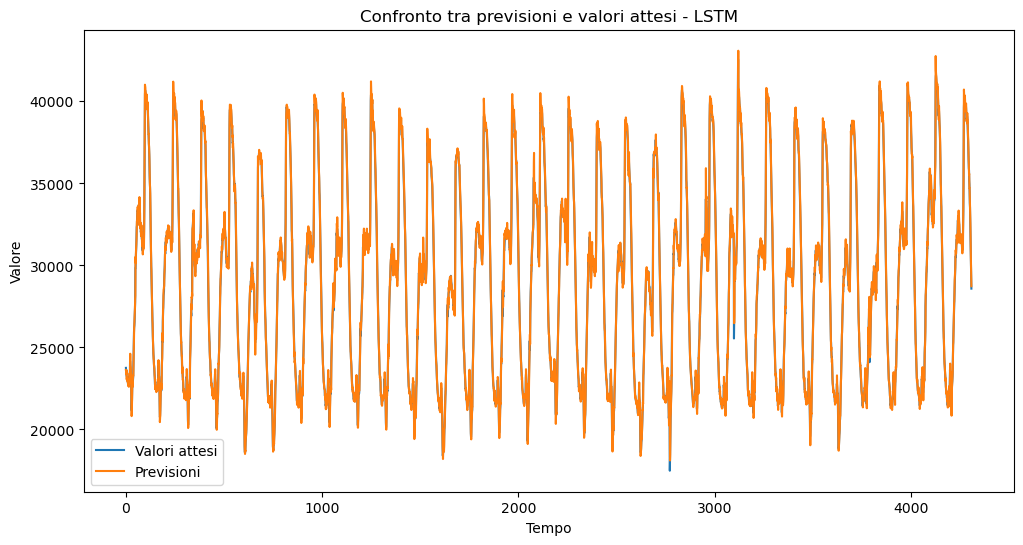

In [14]:
# Plot previsioni contro valori attesi
plt.figure(figsize=(12, 6))
plt.plot(y_test_LSTM_denorm, label='Valori attesi')
plt.plot(predictions_LSTM_denorm, label='Previsioni')
plt.xlabel('Tempo')
plt.ylabel('Valore')
plt.title('Confronto tra previsioni e valori attesi - LSTM')
plt.legend()
# Salva il grafico ad alta qualità
#plt.savefig('RNN_previsioni.png', dpi=300, bbox_inches='tight')
plt.show()